# IBM Developer Skills Network

# Final Project Fashion_MNIST dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(0)

In [1]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image

In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

# Create Dataset Class

In [4]:
IMAGE_SIZE = 16

transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
transforms.ToTensor()
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [5]:
# train and validation dataset
dataset_train = dsets.FashionMNIST(root = '.fashion/data', train=True, transform=composed, download=True)
dataset_val = dsets.FashionMNIST(root = '.fashion/data', train=False, transform=composed, download=True)

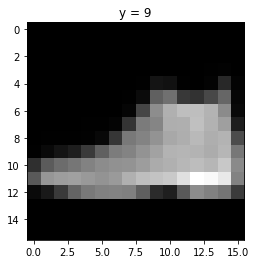

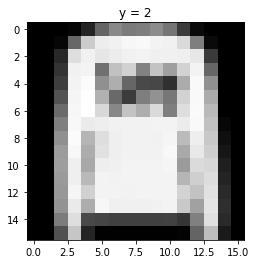

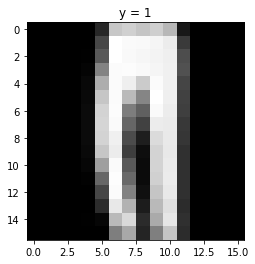

In [6]:
for n,data_sample in enumerate(dataset_val):

    show_data(data_sample)
    plt.show()
    if n==2:
        break 

# Check GPU

In [7]:
torch.cuda.is_available()

True

In [9]:
# create a device
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

# Create the convolutional neural network

In [10]:
# with batch norm
class CNN_batch(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x


In [11]:
# Without batch norm
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
        

In [12]:
# Data loader
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
test_loader = DataLoader(dataset=dataset_val, batch_size=100)

In [13]:
model = CNN(out_1=16, out_2=32,number_of_classes=10)
model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [14]:
# loss model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [15]:
import time
start_time = time.time()

cost_list = []
accuracy_list = []
N_test = len(dataset_val)
n_epochs = 5

for epoch in range(n_epochs):
    cost = 0
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)  # using GPU for training

        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost += loss.item()
    
    correct = 0
    model.eval()
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device) # using GPU

        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)


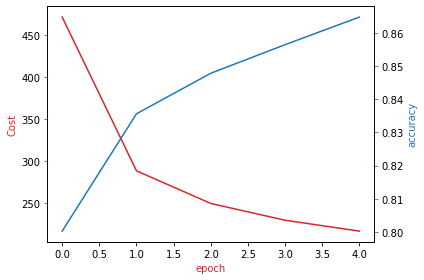

In [17]:
# Plot the accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [18]:
# With batch norm
model_BN =CNN_batch(out_1=16, out_2=32,number_of_classes=10)
model_BN.to(device)  # using gpu

CNN_batch(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
  (bn_fc1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [20]:
import time
start_time = time.time()

cost_list=[]
accuracy_list=[]
N_test=len(dataset_val)
n_epochs=5
for epoch in range(n_epochs):
    cost=0
    model_BN.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device) # using gpu

        optimizer.zero_grad()
        z = model_BN(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.item()
    correct=0

    # perform a prediction on the validation  data 
    model_BN.eval()
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)

        z = model_BN(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()

    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)

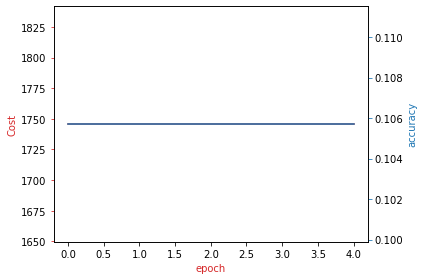

In [21]:
# Plot the accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()